## Automatic Speech Recognition(ASR) for Swahili.

### Business understanding.



Automatic speech recognition (ASR) is a computer speech recognition that enables a program to process human speech into written format. A Swahili ASR is, therefore, capable of converting Swahili speech to written format. Such a program will be of use to swahili Speakers and can be used in various applications, for instance, search by voice on websites and building of virtual assistant technology based on the ASR model. Swahili language spoken in various countries especially in East and Central Africa. The Swahili ASR will be of use to many people. Consequently, the aim of this project will be to build an Automatic Speech Recognition Model for the Swahili language and deploy as a web service using flask.

### Data understanding

The data that will be used in this project was obtained from [Mozilla Common Voice](https://commonvoice.mozilla.org/en/datasets). It contains thousands of audios in Swahili and their corresponding transcripitions. The audios are diverse to ensure that the model is trained on various voices and avoid building a biased model. The corresponding transcriptions will also be used to train the model. An extra fine-tuned Swahili language model will be used to improve the models output and ensure that the written format is as close as possible to the speech.

### Exploring the dataset

In [1]:
# Importing and mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Changing to the respective directory
import os
os.chdir('/content/drive/MyDrive/SWAHILI_ASR')

In [ ]:
# Importing the relevant libraries
import pandas as pd
# Loading the dataset with transcripitions
transcriptions = pd.read_csv("train.tsv",sep ="\t",low_memory = False)
transcriptions.head(5)

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,0133d8ddf5c1a3c678fde017e0b07d2835bfd707d5b3ec...,common_voice_sw_31428161.mp3,wachambuzi wa soka wanamtaja Messi kama nyota ...,2,0,twenties,female,NaN,NaN,sw,NaN
1,41ba4752c376dc7f0502f9c97728bf2f54e47972f3b6e4...,common_voice_sw_30356664.mp3,wachambuzi wa soka wanamtaja Messi kama nyota ...,2,0,fourties,female,NaN,NaN,sw,NaN
2,01c95772efd3fbe4a1122206c7474c77ed6591c8c9fb00...,common_voice_sw_30317714.mp3,romario aliingia kwenye orodha ya wachezaji wa...,2,1,NaN,NaN,NaN,NaN,sw,NaN
3,055aa825d52f0b81c0861c88ba4999b8bf91b92e90866c...,common_voice_sw_30055356.mp3,romario aliingia kwenye orodha ya wachezaji wa...,2,1,twenties,female,NaN,NaN,sw,NaN
4,0244639ffd7ec755a01b21ea204735ca3c44443e9cf46c...,common_voice_sw_29002392.mp3,Inajulikana kama shina la Warangi.,2,0,NaN,NaN,NaN,NaN,sw,NaN


In [ ]:
# Exploring the length of the tsv file
print(len(transcriptions))

82070


In [ ]:
# Exploring how many transcriptions have down votes greater than zero
len(transcriptions[transcriptions["down_votes"]>0])

26616

In [ ]:
# Exploring how many transcriptions have down votes greater than one
len(transcriptions[transcriptions["down_votes"]>1])

3845

In [ ]:

# Exploring how many transcriptions have down votes greater than two
len(transcriptions[transcriptions["down_votes"]>2])

1271

In [ ]:
transcriptions[transcriptions["up_votes"]==0]

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment


In [ ]:
transcriptions[transcriptions["up_votes"]==1]

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment


From the above outputs it can be seen that all audios have an up_vote greater than one. However, on sampling some of the audios with down_votes it can be realised that most audios with down_votes of two or less are okay. However, one audio with a down_vote of five seemed to have a lot of noise. Therefore, as a rule of thumb, we can avoid audios with a down_vote greater than two.

In [ ]:
# Exploring the variability of the dataset on the basis of age
transcriptions['age'].value_counts()

age
twenties    36762
thirties     7462
fourties     4001
fifties      3865
sixties       506
teens         100
Name: count, dtype: int64

<Axes: xlabel='age'>

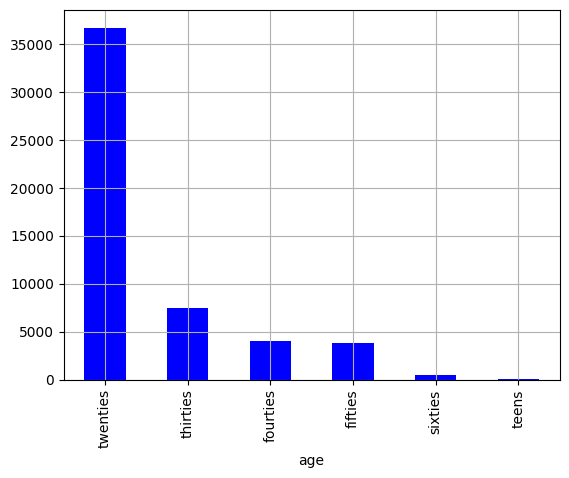

In [ ]:
# Plotting the variability on the basis of age
transcriptions['age'].value_counts().plot(kind='bar',grid=True,colormap='winter')

The data seems to be diverse and tries to capture the voices of most age groups.However the teens and sixties audios are not that much.

In [ ]:
# Exploring the variability of the dataset on the basis of gender
transcriptions['gender'].value_counts()

gender
female    30325
male      23549
other        36
Name: count, dtype: int64

<Axes: xlabel='gender'>

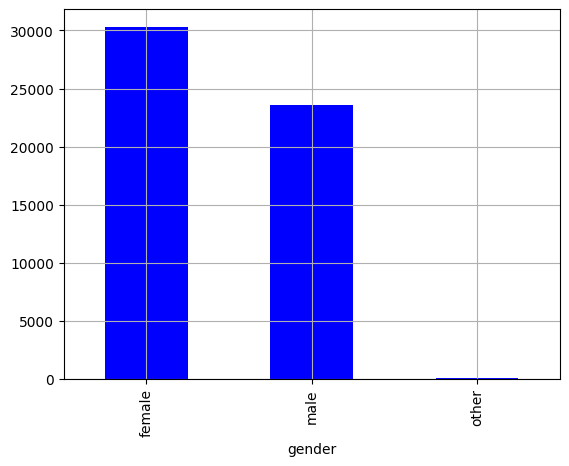

In [ ]:
# Plotting the variability of the dataset on the basis of gender
transcriptions['gender'].value_counts().plot(kind='bar',grid=True,colormap='winter')

The data captures the gender audios in a seemingly unbiased manner

In [ ]:
# Exploring to see if the dataset contains audios with a different locale than Swahili
transcriptions['locale'].unique()

array(['sw'], dtype=object)

Only Swahili audios are used as it should be, since we are building a Swahili ASR

### Data preprocessing

In [ ]:
# Taking a look at the dataset
transcriptions.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,0133d8ddf5c1a3c678fde017e0b07d2835bfd707d5b3ec...,common_voice_sw_31428161.mp3,wachambuzi wa soka wanamtaja Messi kama nyota ...,2,0,twenties,female,NaN,NaN,sw,NaN
1,41ba4752c376dc7f0502f9c97728bf2f54e47972f3b6e4...,common_voice_sw_30356664.mp3,wachambuzi wa soka wanamtaja Messi kama nyota ...,2,0,fourties,female,NaN,NaN,sw,NaN
2,01c95772efd3fbe4a1122206c7474c77ed6591c8c9fb00...,common_voice_sw_30317714.mp3,romario aliingia kwenye orodha ya wachezaji wa...,2,1,NaN,NaN,NaN,NaN,sw,NaN
3,055aa825d52f0b81c0861c88ba4999b8bf91b92e90866c...,common_voice_sw_30055356.mp3,romario aliingia kwenye orodha ya wachezaji wa...,2,1,twenties,female,NaN,NaN,sw,NaN
4,0244639ffd7ec755a01b21ea204735ca3c44443e9cf46c...,common_voice_sw_29002392.mp3,Inajulikana kama shina la Warangi.,2,0,NaN,NaN,NaN,NaN,sw,NaN


In [ ]:
# Dropping irrelevant columns
transcriptions.drop(['age','gender','accents','variant','locale','segment'],axis=1,inplace=True)

In [ ]:
transcriptions.columns

Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes'], dtype='object')

#### Dealing with missing values

In [ ]:
# Checking for missing values
transcriptions.isna().sum()

client_id     0
path          0
sentence      0
up_votes      0
down_votes    0
dtype: int64

The new dataset has no missing values.

#### Dealing with duplicates

While duplicated data can be advantageuous since it helps increase the size of the dataset, it can result in a biased model in extreme situations.We can define a duplicate has having the same client_id, sentence and or path. We will therefore check for duplicates while subsetting it to the said columns.If there are duplicates in extreme levels we will have to drop them.

In [ ]:
# Checking for duplicates with client_id and sentence as the subset
transcriptions.duplicated(subset=['client_id','sentence']).sum()

0

In [ ]:
# Checking for duplicates with path as the subset
transcriptions.duplicated(subset=['path']).sum()

0

The dataset has no duplicates. We can now create a dataframe containing only the transcriptions(text) and the path.

In [ ]:
transcriptions_df = pd.DataFrame(transcriptions[['sentence','path']])
transcriptions_df.head()

,sentence,path
0,wachambuzi wa soka wanamtaja Messi kama nyota ...,common_voice_sw_31428161.mp3
1,wachambuzi wa soka wanamtaja Messi kama nyota ...,common_voice_sw_30356664.mp3
2,romario aliingia kwenye orodha ya wachezaji wa...,common_voice_sw_30317714.mp3
3,romario aliingia kwenye orodha ya wachezaji wa...,common_voice_sw_30055356.mp3
4,Inajulikana kama shina la Warangi.,common_voice_sw_29002392.mp3


In [ ]:
# Creating a class to convert the audios to WAV form and match each audio to its respective transcription.
# Installing the relevant libraries
!pip install pydub
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Normalizing and removing special characters

Special characters i.e ,.? cannot be represented as acoustic sounds. Since we are dealing with an acoustic model we will have to remove these characters as they only add to the model complexity. We will also normalize all transcriptions to lowercase. There is no difference in sound between V and v.

We will start by taking a look at some of the transcriptions in the sentence column.

In [ ]:
transcriptions_df['sentence'].sample(10)

10431                          Nikitoa machozi mengi sana.
75645    Serikali Kuu ilizirudisha Serikali za Mitaa nc...
53372        Hii ni kwa wale wanaofanya kazi mikoa tofauti
74185          karol alikuwa anafahamu lugha kumi na mbili
60154    Ningejua mapema ile ilikuwa ndiyo alama yangu ...
76940    Pia zipo bandari kavu katika maeneo mbalimbali...
46643                  alitatua kero kwa maneno na vitendo
896      tayari mahakama inayoshughulikia kesi hiyo ime...
15796    Lakini tatizo hili linapatikana pia Ulaya, Asi...
77936           Zikifanya kazi za aina mbalimbali baharini
Name: sentence, dtype: object

In [ ]:
# Setting the display in order to see the entire columns
pd.set_option('display.max_colwidth',None)
transcriptions_df['sentence'].sample(10)

2562                                   Hadi mwaka wa elfu moja mia tisa sitini na mbili
20098                                  kupanda mlima Meru kunachukua siku tatu hadi nne
548                                                                       Mzee amerudi.
75620                    Tumejaliwa kuwa na mlima mrefu barani afrika mlima kilimanjaro
54960            Sherehe za wanawake zinafanyika mahususi kutokana na wasiwasi walionao
46774                                                        Mtwara Kusini mwa Tanzania
73293       Ni nywele safi zenye ubora wa hali ya juu hazifungamani zipo katika mawimbi
49442                                  Uchumi wa Uganda ulipungua na mfumuko wa bei pia
12429    Aliazimia kugombea tena urais lakini Chiluba alifanya ujanja na kumzuia Kaunda
10952                     Ambao wengi ni wakazi wa maeneo ya Afrika ya Jangwa la Sahara
Name: sentence, dtype: object

In [ ]:
# Normalize the transcriptions to lowercase
transcriptions_df['sentence']=transcriptions_df['sentence'].apply(lambda x: x.lower())

In [ ]:
# Removing the special characters
import re
transcriptions_df['sentence'] = transcriptions_df['sentence'].str.replace(r'[,.?!-_:;\"]','',regex=True)
transcriptions_df['sentence']

0                       wachambuzi wa soka wanamtaja messi kama nyota hatari zaidi duniani
1                       wachambuzi wa soka wanamtaja messi kama nyota hatari zaidi duniani
2           romario aliingia kwenye orodha ya wachezaji waliyofanya vizuri kwenye michuano
3           romario aliingia kwenye orodha ya wachezaji waliyofanya vizuri kwenye michuano
4                                                        inajulikana kama shina la warangi
                                               ...                                        
82065                hapo nadhani nawe unazikumbuka ajali kadhaa ambazo tayari zimshatokea
82066                         juu zaidi usimbishaji unapungua tena hadi milimita mia mbili
82067                              lakini hakuwa na muda mwingi wa kucheza kwani ilipofika
82068    hivi sasa ukoo huo wakichifu uko kwenye mchakato wa kutafiti mrithi wa kiti hicho
82069     akadai ibada ziendeshwe katika lugha za watu na si tena katika lugha ya kilatini

In [ ]:
# Resetting the display
pd.reset_option('display.max_colwidth')
transcriptions_df.head()

,sentence,path
0,wachambuzi wa soka wanamtaja messi kama nyota ...,common_voice_sw_31428161.mp3
1,wachambuzi wa soka wanamtaja messi kama nyota ...,common_voice_sw_30356664.mp3
2,romario aliingia kwenye orodha ya wachezaji wa...,common_voice_sw_30317714.mp3
3,romario aliingia kwenye orodha ya wachezaji wa...,common_voice_sw_30055356.mp3
4,inajulikana kama shina la warangi,common_voice_sw_29002392.mp3


### Creating a Wav2Vec2CTCTokenizer

A wav2vec2 model consists of a tokenizer and feature extractor.The feature extractor converts the audio inputs to the format required by the model and the tokenizer converts the model output to text.

For the tokenizer we will create a dictionary consisting of words as keys and their corresponding number as values.Space will also be included in the dictionary since the model needs to learn to predict when a word is finished.

In [ ]:
# Creating a dictionary for the tokenizer
# The '|' will act as the word delimiter
vocab_dict = {letter: index for index,letter in enumerate("|abcdefghigklmnopqrstuvwxyz")}
vocab_dict

{'|': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 10,
 'h': 8,
 'i': 9,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

Some swahili words contain apostrophe(') for instance "ng'ombe" we will have to include it in the dictionary. This is why (') was not included in the regex pattern that was created.

In [ ]:
# Adding "'" to the dictionary
vocab_dict["'"]=27
vocab_dict

{'|': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 10,
 'h': 8,
 'i': 9,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 "'": 27}

Next we will add a padding token that corresponds to the CTC "blank token" and an unkown token to handle tokens not present in the dictionary.

In [ ]:
vocab_dict["[UNK]"] = 28
vocab_dict["[PAD]"] = 29

In [ ]:
vocab_dict

{'|': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 10,
 'h': 8,
 'i': 9,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 "'": 27,
 '[UNK]': 28,
 '[PAD]': 29}

In [ ]:
# Saving the dictionary as a json file
# Importing the json library
import json
with open('vocab.json', 'w') as vocab_file:
  json.dump(vocab_dict,vocab_file)

In [ ]:
# Checking to see if the file has been saved
with open('vocab.json', 'r') as vocab_file:
  dictionary = json.load(vocab_file)

print(dictionary)

{'|': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 10, 'h': 8, 'i': 9, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, "'": 27, '[UNK]': 28, '[PAD]': 29}


In [6]:
# Installing transformers
!pip install transformers

In [ ]:
# Creating the Wav2Vec2CTCTokenizer using the loaded dictionary
from transformers import Wav2Vec2CTCTokenizer
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained('./',unk_token = '[UNK]',pad_token = '[PAD]',word_delimiter_token = '|')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Creating a Wav2Vec2FeatureExtractor

In [ ]:
# Importing the relevant packages
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1,sampling_rate=16000,padding_value=0.0,return_attention_mask=True,do_normalize=True)

## Creating a Wav2Vec2Processor

Next we will create a processor from the feature extractor and tokenizer that we created so that we only use a processor and model object.

In [ ]:
# Importing the relevant package
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor,tokenizer=tokenizer)

## Further preprocessing

Next we will match the audios to their respective transcriptions using their respective paths.We will also convert the audios to a WAV format since we are using a wav2vec2 acoustic model.

In [ ]:
# Importing the relevant libraries
import torchaudio
import torch
from torch.utils.data import Dataset,DataLoader
from pydub import AudioSegment
import tempfile
import os

In [ ]:
import warnings

# Suppress the specific UserWarning from the processing_wav2vec2 module
warnings.filterwarnings("ignore", category=UserWarning, module="transformers.models.wav2vec2.processing_wav2vec2")


In [ ]:
# Creating a function to convert and load the audio in wav format.
def audio_prep(dataframe):

    audio_folder_path = "train"
    data_frame= []

    # Iterate through each row in the DataFrame
    for index, row in dataframe.iterrows():
        mp3_audio = row['path']
        audio_file_path = f'{audio_folder_path}/{mp3_audio}'
        try:

          # Loading the audio file and convert to WAV using pydub
          audio = AudioSegment.from_file(audio_file_path)
          audio = audio.set_frame_rate(16000)

          # Creating a temporary WAV file
          temp_wav_file = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
          temp_wav_file_path = temp_wav_file.name
          temp_wav_file.close()

          audio.export(temp_wav_file_path, format="wav")

          # Loading the converted audio file using torchaudio
          waveform, sample_rate = torchaudio.load(temp_wav_file_path)

          # Removing the temporary WAV file
          os.remove(temp_wav_file_path)

          inputs = processor(waveform.squeeze().numpy(),sampling_rate=sample_rate).input_values[0]

          with processor.as_target_processor():
              labels = processor(row['sentence']).input_ids
          # labels = processor(row['sentence'], return_tensors="pt").input_ids

          # Create a dictionary with the processed data
          # Use setdefault to initialize the lists if they don't exist
          row_df = pd.DataFrame({'inputs':[inputs],'input_lengths':[len(inputs)],'labels':[labels]})
          data_frame.append(row_df)
        except (FileNotFoundError,OSError):
          continue


        # Create a DataFrame for each row and concatenate them
    results_df = pd.concat(data_frame,ignore_index=True)

    return results_df


Since google colab has a runtime and we have over 80,000 audios we will load the audios in batches then later join the datasets to form one complete dataset with all the input values of the audios.

In [ ]:
# Loading the first 10000 audios using the audio_prep function
df_1 = audio_prep(transcriptions_df.iloc[:10000,:])
# Saving the dataframe in drive
df_1.to_parquet('df_1.parquet',index=False)

In [ ]:
# Loading the second 10000 audios using the audio_prep function
df_2 = audio_prep(transcriptions_df.iloc[10000:20000,:])
# Saving the dataframe in drive
df_2.to_parquet('df_2.parquet',index=False)

In [ ]:
# Loading the third 10000 audios using the audio_prep function
df_3=audio_prep(transcriptions_df.iloc[20000:30000,:])
# Saving the dataframe in drive
df_3.to_parquet('df_3.parquet',index=False)

In [ ]:
# Loading the fourth 10000 audios using the audio_prep function
df_4 = audio_prep(transcriptions_df.iloc[30000:40000,:])
# Saving the dataframe in drive
df_4.to_parquet('df_4.parquet',index=False)

In [ ]:
# Loading the fifth 10000 audios using the audio_prep function
df_5 = audio_prep(transcriptions_df.iloc[40000:50000,:])
# Saving the dataframe in drive
df_5.to_parquet('df_5.parquet',index=False)

In [ ]:
# Loading the sixth 10000 audios using the audio_prep function
df_6 = audio_prep(transcriptions_df.iloc[50000:60000,:])
# Saving the dataframe in drive
df_6.to_parquet('df_6.parquet',index=False)

In [ ]:
# Loading the seventh 10000 audios using the audio_prep function
df_7 = audio_prep(transcriptions_df.iloc[60000:70000,:])
# Saving the dataframe in drive
df_7.to_parquet('df_7.parquet',index=False)

In [ ]:
# Loading the remaining audios using the audio_prep function
df_8 = audio_prep(transcriptions_df.iloc[70000:,:])
# Saving the dataframe in drive
df_8.to_parquet('df_8.parquet',index=False)

### Loading the processed audios.

We managed to process about 30,000 audios before we ran out of RAM when using colab.The model will be trained using the available data as we look for a way of processing all the audios.The three datasets will be used to train the model one at a time

In [ ]:
# Loading the dataframes
# df_1 = pd.read_parquet('df_1.parquet')
# df_2 = pd.read_parquet('df_2.parquet')
# df_3 = pd.read_parquet('df_3.parquet')
# df_4 = pd.read_parquet('df_4.parquet')
# df_5 = pd.read_parquet('df_5.parquet')
# df_6 = pd.read_parquet('df_6.parquet')
# df_7 = pd.read_parquet('df_7.parquet')
# df_8 = pd.read_parquet('df_8.parquet')

In [ ]:
# Loading the first processed dataframe
import pandas as pd
df_1p = pd.read_parquet('df_2.parquet')
df_1p.head()

,inputs,input_lengths,labels
0,"[-2.8247086e-07, -2.8247086e-07, -2.8247086e-0...",118080,"[9, 12, 9, 21, 14, 4, 23, 1, 0, 11, 1, 21, 12,..."
1,"[0.0006630008, 0.0006630008, 0.0006630008, 0.0...",76608,"[8, 1, 23, 1, 0, 23, 15, 20, 5, 0, 23, 1, 12, ..."
2,"[-0.00012974262, -0.00012974262, -0.0001297426...",55296,"[8, 1, 23, 1, 0, 23, 15, 20, 5, 0, 23, 1, 12, ..."
3,"[0.0005171415, 0.0005171415, 0.0005171415, 0.0...",135360,"[13, 1, 20, 1, 20, 9, 26, 15, 0, 25, 1, 14, 1,..."
4,"[7.5258155e-05, 7.5258155e-05, 7.5258155e-05, ...",105408,"[13, 1, 20, 1, 20, 9, 26, 15, 0, 25, 1, 14, 1,..."


### SPLITTING THE DATASET

In [ ]:
# Due to limited resources(limited RAM) we will choose a section of the dataset
df_1p = df_1p.loc[:2500]
df_1p.head()

,inputs,input_lengths,labels
0,"[-2.8247086e-07, -2.8247086e-07, -2.8247086e-0...",118080,"[9, 12, 9, 21, 14, 4, 23, 1, 0, 11, 1, 21, 12,..."
1,"[0.0006630008, 0.0006630008, 0.0006630008, 0.0...",76608,"[8, 1, 23, 1, 0, 23, 15, 20, 5, 0, 23, 1, 12, ..."
2,"[-0.00012974262, -0.00012974262, -0.0001297426...",55296,"[8, 1, 23, 1, 0, 23, 15, 20, 5, 0, 23, 1, 12, ..."
3,"[0.0005171415, 0.0005171415, 0.0005171415, 0.0...",135360,"[13, 1, 20, 1, 20, 9, 26, 15, 0, 25, 1, 14, 1,..."
4,"[7.5258155e-05, 7.5258155e-05, 7.5258155e-05, ...",105408,"[13, 1, 20, 1, 20, 9, 26, 15, 0, 25, 1, 14, 1,..."


In [ ]:
# Importing the relevant packages
from sklearn.model_selection import train_test_split
# Assigning features to X and labels to Y
X = df_1p['inputs']
y = df_1p['labels']
X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.3, random_state=42)


In [ ]:
X_train.shape

(1750,)

### TRAINING THE FIRST DATASET

#### SETTING UP THE DATA COLLATOR

This data collator was extracted from github. It takes in the values in dictionary format,performs padding,batching and special token handling.

In [ ]:
# Installing all the necessary packages for training
!pip install datasets
!pip install huggingface_hub
!pip install torchaudio
!pip install librosa
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next we will create dictionaries from the train dataset and test dataset since the datacollator only allows a dictionary format and not a pandas dataframe.

In [ ]:
# Creating a dictionary from the train and test datasets of the first processed dataframe
train_data = {'input_values': X_train, 'labels': Y_train}
test_data = {'input_values': X_test, 'labels': Y_test}
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
train_df = train_df.to_dict(orient='records')
test_df = test_df.to_dict(orient='records')

In [ ]:
# Installing the transformers library with support for PyTorch
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Upgrading the accelerate version to the most recent version
# Accelerate is used to scale up training accros multiple GPUs
!pip install accelerate -U

In [3]:
# Logging in to huggingface_hub
# The access token was extacted from my huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Installing git-lfs to manage large files more efficiently
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# Pushing the tokenizer to the model in huggingface_hub
repo_name = "asr_2500"
tokenizer.push_to_hub(repo_name)


README.md:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/William-Ndoni-254/asr_2500/commit/ef35013b0c2466d74f54d4cb57ed6ef800b24915', commit_message='Upload tokenizer', commit_description='', oid='ef35013b0c2466d74f54d4cb57ed6ef800b24915', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Importing load_metric that will be used to calculate the word error rate
from datasets import load_metric
wer_metric = load_metric("wer")

<ipython-input-20-312f2d700395>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# Importing numpy
import numpy as np
# Creating a function to calculate the wer
def compute_metrics(pred):
  pred_logits = pred.predictions
  pred_ids = np.argmax(pred_logits, axis=-1)

  pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

  pred_str = processor.batch_decode(pred_ids)
  # we do not want to group tokens when computing the metrics
  label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

  wer = wer_metric.compute(predictions=pred_str, references=label_str)

  return {"wer": wer}


In [ ]:
# Creating the model
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.0,
    ctc_zero_infinity = True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)
model.freeze_feature_extractor()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1914: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [ ]:
# Loading the training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=8,
  gradient_accumulation_steps=4,
  evaluation_strategy="steps",
  num_train_epochs=30,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=400,
  eval_steps=400,
  logging_steps=400,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
  push_to_hub=True,
)


In [ ]:
# Creating the model trainer
# The trainer loads the loaded model
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_df,
    eval_dataset=test_df,
    tokenizer=processor.feature_extractor,
)


In [ ]:
# Training the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
400,3.664700,0.640375,0.568192
800,0.277300,0.481386,0.401007
1200,0.098900,0.477913,0.338516
1600,0.053400,0.473591,0.308456


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Tran

TrainOutput(global_step=1620, training_loss=1.0114445434308346, metrics={'train_runtime': 4419.1735, 'train_samples_per_second': 11.88, 'train_steps_per_second': 0.367, 'total_flos': 9.050914350937405e+18, 'train_loss': 1.0114445434308346, 'epoch': 29.589041095890412})

Next we will upload the results of training to the hub. From the hub the model can be loaded and shared.

In [ ]:
# Pushing the model to the huggingfacehub
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1714971556.4f199cc62acc.8751.0:   0%|          | 0.00/8.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/William-Ndoni-254/asr_2500/commit/a092395018df35239bc794010d56206432dc4b06', commit_message='End of training', commit_description='', oid='a092395018df35239bc794010d56206432dc4b06', pr_url=None, pr_revision=None, pr_num=None)

## Evaluation

In [ ]:
# Loading the pre-trained model from the hub repo
model = Wav2Vec2ForCTC.from_pretrained(repo_name).to('cuda')

In [ ]:
# Loading the processor
processor = Wav2Vec2Processor.from_pretrained(repo_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Testing using the first example in the dataset
input_dict = processor(df_1p.iloc[0,0], return_tensors="pt", padding=True,sampling_rate=16000)

logits = model(input_dict.input_values.to("cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)[0]


Next we will compare the predictions of the model to the actual transcriptions

In [ ]:
# Printing the outputs of the first transcriptions
x = df_1p['labels'][0]
print(processor.decode(x))

iliundwa kaulimbiu ya uhuru mandela na mwanahabari percy qoboza


In [ ]:
# Printing the predicted text
print(processor.decode(pred_ids))

iliundwa kaulimbiu ya uhuru mandela na mwanahabari percy coboza


The model performs really well. Only the last word was not well predicted.

Limited resources forced us to use lesser data otherwise colab runtime would crash. However, for the little data used the model performed really well.

To have a view of the training metrics click this link https://huggingface.co/William-Ndoni-254/asr_2500/tensorboard . It will lead you to the hugging face tensorboard.

### Saving the model

In [7]:
# Loading the model from huggingface hub
from transformers import Wav2Vec2ForCTC
model = Wav2Vec2ForCTC.from_pretrained("William-Ndoni-254/asr_2500").to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [9]:
# Loading the processor  from huggingface hub
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("William-Ndoni-254/asr_2500")

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/887 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

In [11]:
# Saving the model amd processor
model.save_pretrained('model')
processor.save_pretrained('processor')

[]

### Model deployment using flask
Next we will deploy the model in flask to see how it works on audio recorded in real time.